This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

In [146]:
# import libraries
import pandas as pd
import pickle
import stationarity as st
import load_data as ld
import arima_grid_search as ags
import summarize
import test_prediction_save_forecast_1day as tpsf1
import multi_step_forecast as msf

In [170]:
# Prepare arguments for driver
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\linds\OneDrive\mystuff\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Country_Region',
            'place': 'United Kingdom',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'p_values': range(0,3),
            'd_values': range(0,3),
            'q_values': range(0,3),
            'split_value': .5,
            'bias': 0,
            'date': '12-31-2020'}

The "data date" is 2020-05-18 00:00:00

ADF Statistic: -5.981379
p-value: 0.000000
Critical Values:
	1%: -3.532
	5%: -2.906
	10%: -2.590


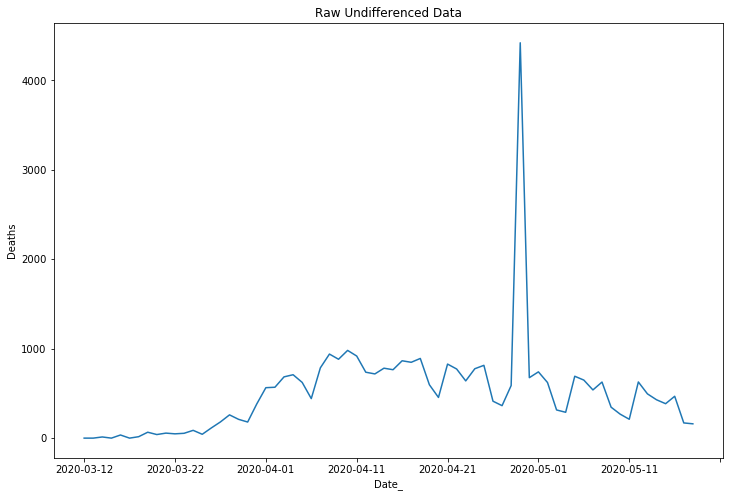

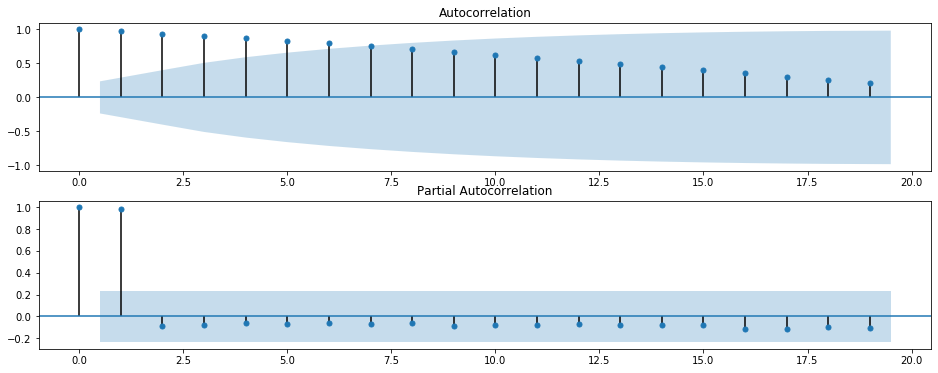

ARIMA(0, 0, 1) RMSE=13181.534
ARIMA(0, 1, 1) RMSE=958.505
ARIMA(1, 0, 0) RMSE=960.040
ARIMA(1, 1, 0) RMSE=904.314
Best ARIMA(1, 1, 0) RMSE=904.314
RMSE: 904.314
                 0
count    35.000000
mean     97.571024
std     912.159724
min   -3500.796352
25%     -31.726833
50%      79.854029
75%     214.152117
max    3853.289018


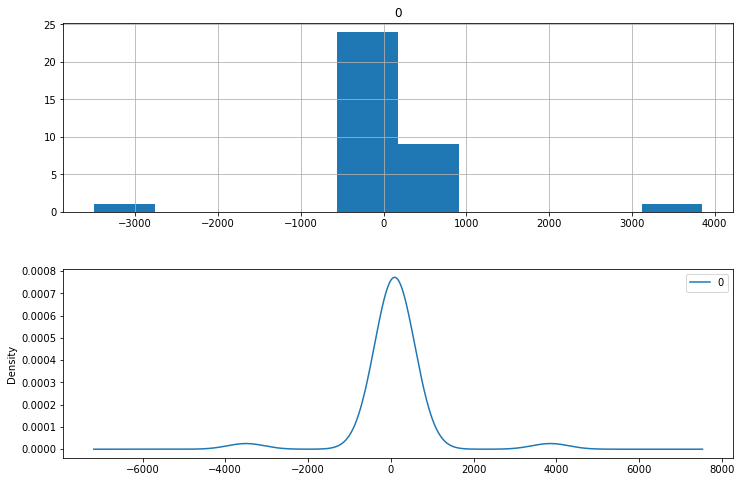


bias saved in arg_dict["bias"] for subsequent run is: 97.57102369919183 

RMSE: 899.034
                  0
count  3.500000e+01
mean   1.039423e-13
std    9.121597e+02
min   -3.598367e+03
25%   -1.292979e+02
50%   -1.771699e+01
75%    1.165811e+02
max    3.755718e+03


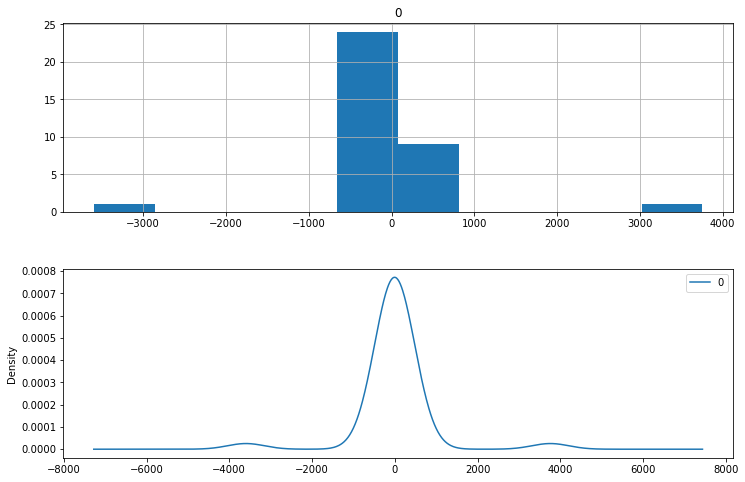


bias saved in arg_dict["bias"] for subsequent run is: 1.039422516311918e-13 



In [171]:
# Driver cell

# Need to load John Hopkins data
df, li_set = ld.driver(arg_dict)

# Get the date of the last row in the file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save df and arg_dict for subsequent independent processing
df.to_csv('df.csv')
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# Grid search ARIMA parameters 
best_cfg = ags.driver(df, arg_dict)
arg_dict.update({'best_cfg': best_cfg})

# summarize residual errors for an ARIMA model and return bias
bias, test, predictions, model_fit = summarize.driver(df, arg_dict)
arg_dict.update({'bias': bias})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Rerun summarize, as bias adjusted
bias, test, predictions, model_fit = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


The predicted cumulative Deaths for United Kingdom for tomorrow (input data plus 1 day) are 34,916


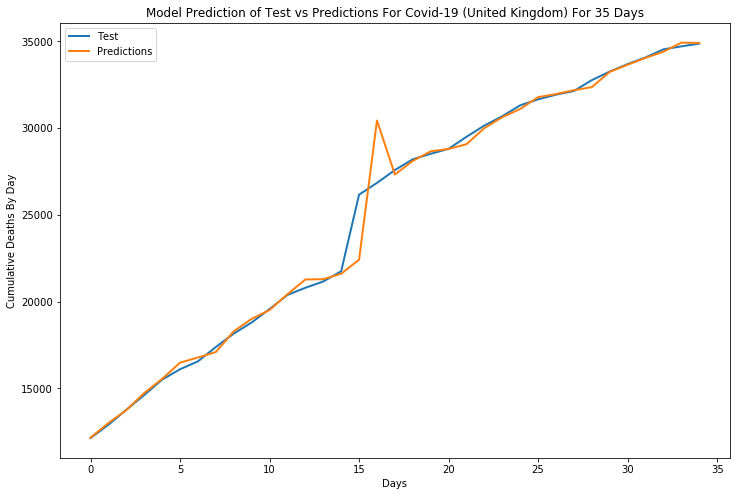

In [172]:
# Plot, save, and forecast
tpsf1.driver(arg_dict)

The United Kingdom prediction is for 452,432 cumulative Deaths to occur by 2020-12-31


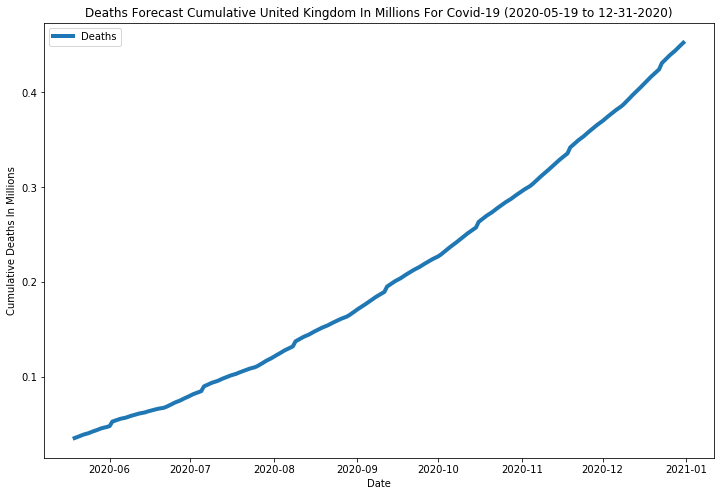

In [173]:
# Multi step forecast
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

In [174]:
df['Daily_Deaths'] = df['Deaths'] - df['Deaths'].shift(1)
df.tail()

,Deaths,Daily_Deaths
Date_,,
2020-05-14,33693.0,429.0
2020-05-15,34078.0,385.0
2020-05-16,34546.0,468.0
2020-05-17,34716.0,170.0
2020-05-18,34876.0,160.0


In [175]:
forecast_df.head()

,Deaths,Deaths_e6
2020-05-19,35601.0,0.035601
2020-05-20,36642.0,0.036642
2020-05-21,37747.0,0.037747
2020-05-22,38925.0,0.038925
2020-05-23,39819.0,0.039819
